In [1]:
import copernicusmarine

ADRIATIC_LATITUDES = (40.0, 45.979)
ADRIATIC_LONGITUDES = (11.5, 20)

# Here we download the data from the satellite for the SST
# on the Adriatic Sea
satellite_dataset = copernicusmarine.open_dataset(
    dataset_id = 'cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021',
    minimum_longitude = ADRIATIC_LONGITUDES[0],
    maximum_longitude = ADRIATIC_LONGITUDES[1],
    minimum_latitude = ADRIATIC_LATITUDES[0],
    maximum_latitude = ADRIATIC_LATITUDES[1],
    variables = ['analysed_sst']
)

# The answer is a dataset with 1 variable (analysed_sst) and three
# "coordinates vectors": latitude, longitude and time; the data has
# not been already downloaded: python is downloading the data in
# the background for us
satellite_dataset

INFO - 2024-05-07T12:23:42Z - Dataset version was not specified, the latest one was selected: "202007"
INFO - 2024-05-07T12:23:42Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-05-07T12:23:43Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset>
Dimensions:       (time: 15566, latitude: 120, longitude: 170)
Coordinates:
  * latitude      (latitude) float32 40.01 40.06 40.11 ... 45.87 45.92 45.97
  * longitude     (longitude) float32 11.5 11.55 11.6 ... 19.86 19.91 19.96
  * time          (time) datetime64[ns] 1981-08-25 1981-08-26 ... 2024-04-06
Data variables:
    analysed_sst  (time, latitude, longitude) float32 ...
Attributes: (12/50)
    Conventions:                CF-1.4 
    DSD_entry_id:               -GOS-L4HRfnd-MED
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    time_coverage_end:          19810825T070000Z
    time_coverage_start:        19810824T190000Z
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    uuid:                        
    westernmost_longitude:      -18.125

In [2]:
# We get the variable while we convert it from Kelvin to Celsius.
# This operations requires a lot of time because it will wait until
# the download is done
satellite_data = satellite_dataset['analysed_sst'] - 273.15

# The data is an xarray DataArray, which is quite similar to a
# numpy array
satellite_data

<xarray.DataArray 'analysed_sst' (time: 15566, latitude: 120, longitude: 170)>
array([[[25.579987, 25.609985, 25.589996, ..., 23.859985, 23.910004,
         23.940002],
        [25.519989, 25.549988, 25.529999, ..., 23.790009,       nan,
               nan],
        [25.450012, 25.450012, 25.429993, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[24.889984, 24.859985, 24.839996, ..., 24.040009, 24.049988,
         24.040009],
        [24.850006, 24.839996, 24.809998, ..., 23.920013,       nan,
               nan],
        [24.779999, 24.790009, 24.769989, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[17.070007, 17.029999, 16.98999 , ..., 16.980011, 16.950012,
         16.950012],
        [17.040009, 17.      , 16.940002, ..., 16.910004,       nan,
               nan],
        [17.019989, 16.959991, 16.869995, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 40.01 40.06 40.11 40.16 ... 45.87 45.92 45.97
  * longitude  (longitude) float32 11.5 11.55 11.6 11.65 ... 19.86 19.91 19.96
  * time       (time) datetime64[ns] 1981-08-25 1981-08-26 ... 2024-04-06

In [3]:
# Now we analyze the data we have just downloaded;
# Here we do not use copernicusmarine anymore.
# First of all, we need a few libraries
import numpy  as np
import xarray as xr
from geopy import distance
import matplotlib.pyplot as plt
from pathlib import Path

# Put here the path of your installation of BIT.SEA
BIT_SEA_DIR = Path('/home/spiani/projects/bit.sea')

import sys
sys.path.append(str(BIT_SEA_DIR))

from basins.basin import SimpleBasin
from basins.region import Rectangle
from basins.V2 import adr1

In [4]:
# We recover the longitudes and the latitudes form the
# dataset and we compute the area of the cells
longitudes = satellite_dataset.longitude.to_numpy()
latitudes = satellite_dataset.latitude.to_numpy()

def get_boundaries(center_positions):
    """
    Given an array that contains the latitudes or the longitudes of the
    centers of some cells, compute the position of the boundary cell
    along the same direction.

    This function computes the boundary between two cells as the middle point
    of their centers.
    """
    cell_boundaries = np.empty(
        (center_positions.shape[0] + 1),
        dtype=center_positions.dtype
    )
    cell_boundaries[1:-1] = (center_positions[1:] + center_positions[:-1]) / 2.
    cell_boundaries[0] = 2 * center_positions[0] - cell_boundaries[1]
    cell_boundaries[-1] = 2 * center_positions[-1] - cell_boundaries[-2]
    return cell_boundaries

lat_boundaries = get_boundaries(latitudes)
lon_boundaries = get_boundaries(longitudes)

grid_dims = (latitudes.shape[0], longitudes.shape[0])

# In this arrays we want to compute the distance when we walk
# along a meridian or a parallel between one boudary of a cell
# to the other side, passing through the center
lat_size = np.empty(grid_dims, latitudes.dtype)
lon_size = np.empty(grid_dims, longitudes.dtype)

for i in range(grid_dims[0]):
    for j in range(grid_dims[1]):
        p1 = (lat_boundaries[i], longitudes[j])
        p2 = (lat_boundaries[i + 1], longitudes[j])
        lat_size[i, j] = distance.distance(p1, p2).km

for i in range(grid_dims[0]):
    for j in range(grid_dims[1]):
        p1 = (latitudes[i], lon_boundaries[j])
        p2 = (latitudes[i], lon_boundaries[j + 1])
        lon_size[i, j] = distance.distance(p1, p2).km

# The area is approximated by the product of the two sizes among the two
# directions
cell_areas = lat_size * lon_size

cell_areas.shape

(120, 170)

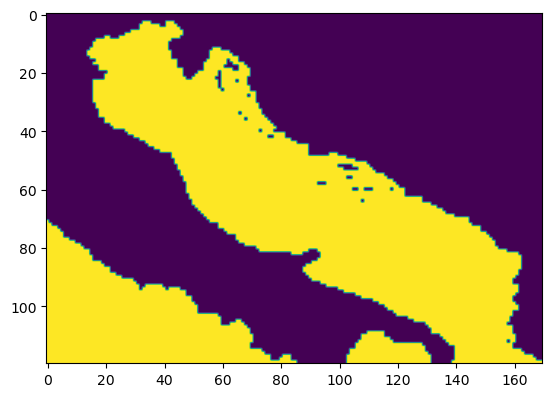

In [5]:
# The cells with water are the ones that do not contain NaN.
# Here we cast the result to be just a numpy array, otherwise it
# woudl have been an xarray DataArray
water_cells = np.logical_not(np.isnan(satellite_data)[0, :]).to_numpy()

plt.imshow(water_cells[::-1])

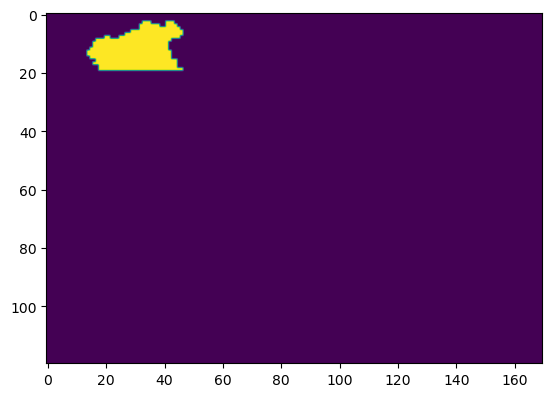

In [6]:
# We construct a basin that contains the Gulf of Trieste,
# starting from 45 degrees north
n45_rect = Rectangle(11., 14., 45., 46.)
basin = SimpleBasin('N45', n45_rect.intersect(adr1.region), 'North of 45°')

# These are the cells that are inside the basin
# We need to use a ".T" because basins in bit.sea use the longitude
# as the first index and the latitude as the second, while we need the
# opposite here
inside_basin_raw = basin.is_inside(longitudes.reshape((-1, 1,)), latitudes).T

# Then we check only the cells that contains water
inside_basin = np.logical_and(
    inside_basin_raw,
    water_cells
)

plt.imshow(inside_basin[::-1])

In [7]:
# Just for fun, we compute the total area and the number of cells
total_area = np.sum(cell_areas[inside_basin])
n_cells = np.sum(inside_basin)
print(f'Area of {total_area} km^2 subdivided in {n_cells} cells')

Area of 8655.8330078125 km^2 subdivided in 396 cells


In [8]:
# We do not need the land cells anymore. We build a new DataArray where we
# drop the longitude and latitude axis and we keep only the water cells.
# Therefore, we loose the information about the geometry and each cell is
# identified just by a number
water_satellite_data = xr.DataArray(
    satellite_data.to_numpy()[:, inside_basin],
    dims=('time', 'cells'),
    coords={'time': satellite_data.time}
)

water_satellite_data

<xarray.DataArray (time: 15566, cells: 396)>
array([[23.040009, 23.230011, 23.380005, ..., 21.929993, 21.920013,
        21.910004],
       [22.51001 , 22.600006, 22.730011, ..., 22.049988, 21.98999 ,
        21.98999 ],
       [22.790009, 22.769989, 22.709991, ..., 22.170013, 22.170013,
        22.190002],
       ...,
       [13.529999, 13.309998, 13.440002, ..., 14.600006, 14.600006,
        14.589996],
       [13.709991, 13.380005, 13.389984, ..., 13.829987, 14.      ,
        14.      ],
       [13.769989, 13.369995, 13.26001 , ..., 14.      , 14.369995,
        14.369995]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-25 1981-08-26 ... 2024-04-06
Dimensions without coordinates: cells

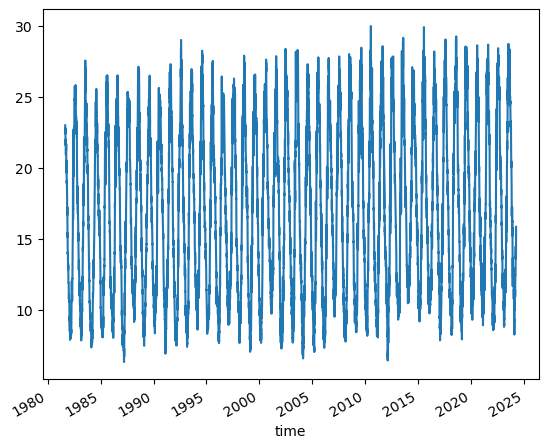

In [9]:
# Finally, we drop also the information on the cells and we keep just the average for
# each timestep
compact_satellite_data = np.sum(
    water_satellite_data * cell_areas[inside_basin],
    axis=-1
)
compact_satellite_data /= total_area

# Here we have the average temperature along the time
_ = compact_satellite_data.plot()